# Visualizing Nubulae

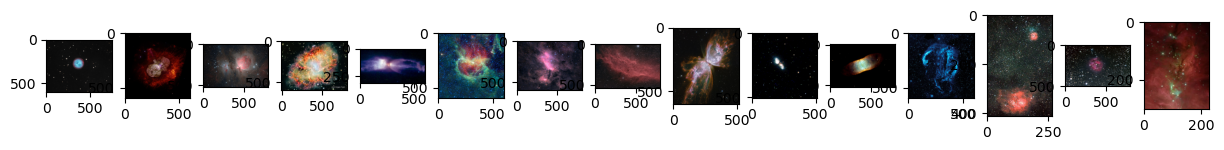

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_
import matplotlib.pyplot as plt
import os
i=0     
# for image_loc,_,images in os.walk('/kaggle/input/pokemon-images-dataset/pokemon/pokemon'):
#     fix,ax = plt.subplots(1,10,figsize=(15,15))
#     for ij in images:
#         if i==10:
#             break
        
#         img = plt.imread(os.path.join(image_loc,ij))
# #         print(img.shape)
#         ax[i].imshow(img[:,:,0:3])
#         i+=1
fix,ax = plt.subplots(1,15,figsize=(15,15))       
for dirname, _, filenames in os.walk('/kaggle/input/nebula-images/Nebulae/Images'):

      
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        if i==15:
            break
        
        img = plt.imread(os.path.join(dirname,filename))
#         print(os.path.join(dirname,filename))
#         print(img.shape)
        ax[i].imshow(img)
        i+=1

# Importing modules and defing crucial functions for diffusion

In [ ]:
import torch
import torch.nn.functional as F
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from IPython.display import clear_output
import numpy as np 
T = 300
def beta_schedule(timestamps, start = 0.0001, end=0.02):
  return torch.linspace(start,end,timestamps)


betas = beta_schedule(timestamps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


def get_index_from_list(vals,t,x_shape):
  batch_size = t.shape[0]
  out = vals.gather(-1,t.cpu())
  return out.reshape(batch_size,*((1,)*(len(x_shape)-1))).to(t.device)

def forward_diffusion(x_0,t,device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)



# Loading image data as tensor plus transforming it

In [ ]:
train_path = glob("../input/nebula-images/Nebulae/Images/*.jpg")
print(len(train_path))
class Dataset(Dataset):
    def __init__(self,images_path,transform_img=None):
        self.images_path = images_path
        self.transform_img = transform_img
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self,idx):
        image = plt.imread(self.images_path[idx])
        shape = image.shape
#         print(shape)
        if len(shape) == 3:
            image = image[:,:,0:3]
#         image,label = img[:,:int(img.shape[1]/2)], img[:,int(img.shape[1]/2):]
            if self.transform_img:
                image = self.transform_img(np.array(image,copy=True))     
            return image
        else:
            return torch.zeros((3,64,64))
    
IMG_SIZE = 64
BATCH_SIZE = 128
transformationImage = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
         # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1),
        
    ]
)

1657


In [ ]:
train_data = Dataset(train_path,transform_img = transformationImage)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Function to view tensor image

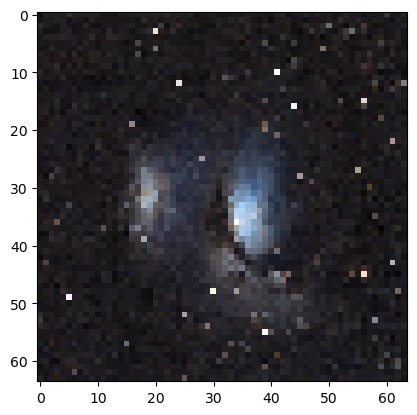

In [ ]:
# train_data[0]
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))
    
show_tensor_image(train_data[150])

if self.transform_img:
                image = self.transform_img(image)     
            return image# Forward Diffusion

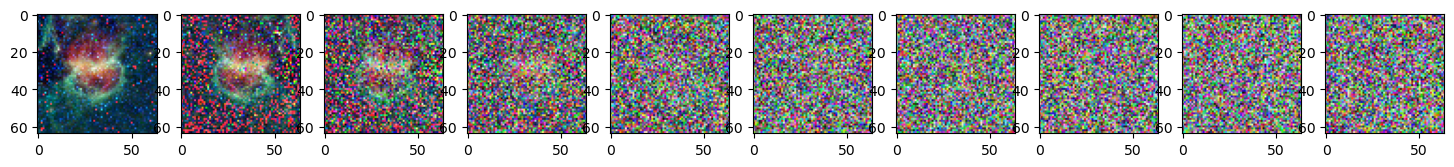

In [ ]:
plt.figure(figsize=(20,20))
plt.axis('off')
num_images = 10
step_size = int(T/num_images)
for t in range(0,T,step_size):
    plt.subplot(1, num_images +1, int(t/step_size) + 1)
#     print(t)
    diff_img,noise = forward_diffusion(train_data[5],torch.Tensor([t]).type(torch.int64))
    show_tensor_image(diff_img)

# U-Net model for Backward Diffusion process

In [ ]:
from torch import nn
import math

class Block(nn.Module):
    def __init__(self,in_ch,out_ch,time_emb_dim,up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim,out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch,out_ch,3,padding=1)
            self.transform = nn.ConvTranspose2d(out_ch,out_ch,4,2,1)
        else:
            self.conv1 = nn.Conv2d(in_ch,out_ch,3,padding=1)
            self.transform = nn.Conv2d(out_ch,out_ch,4,2,1)
        self.conv2 = nn.Conv2d(out_ch,out_ch,3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
    def forward(self,x,t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h=h+time_emb
        h=self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)
        

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128,256,512,1024)
        up_channels = (1024,512,256,128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
#             print(x.shape,"down")
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
#             print(x.shape,"up")
#             print(residual_x.shape,"up")
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)
model = SimpleUnet()
model

SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [ ]:
def get_loss(model,x_0,t):
    x_noisy,noise = forward_diffusion(x_0,t,device)
    noise_pred = model(x_noisy,t)
#     print(noise.shape)
#     print(noise_pred.shape)
#     return F.l1_loss(noise,noise_pred)
    return F.l1_loss(noise,noise_pred)


In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1,3 , img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()  

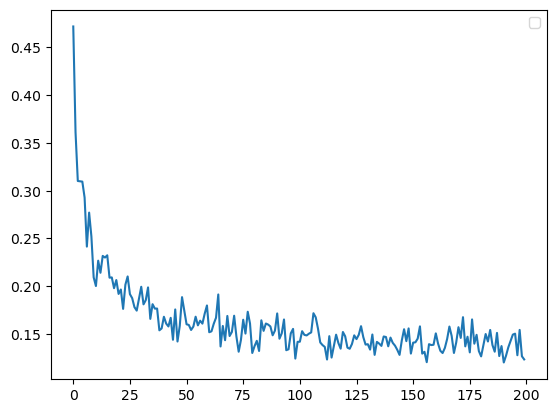

In [ ]:
from torch.optim import Adam 
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(),lr=0.001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1)
epochs = 200
loss_values = []
for epoch in range(epochs):
    for index, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0,T,(BATCH_SIZE,),device=device).long()
#         print(t.shape)
#         print(batch.shape)
# #         print(batch[0][4])
# #         batch = batch[0, :, :, :] 
#         print(batch.shape)
        loss = get_loss(model,batch,t)
        loss.backward()
        optimizer.step()
#         scheduler.step()
        
#             print(epoch)
    loss_values.append(loss.item())
    clear_output(wait = True)
    plt.plot(loss_values)
    plt.legend()
    plt.show()
#             sample_plot_image()
            

In [ ]:
@torch.no_grad()
def sample_loss():
    x_noisy1,noise1 = forward_diffusion(train_data[10],torch.Tensor([50]).type(torch.int64))
    x_noisy1 = x_noisy1.reshape((1,3,64,64))
    noise_pred = model(x_noisy1.to(device),torch.Tensor([50]).type(torch.int64).to(device)).reshape((1,3,64,64))
    print(F.l1_loss(noise1.to(device),noise_pred.to(device)))

In [ ]:
sample_loss()

tensor(0.1465, device='cuda:0')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


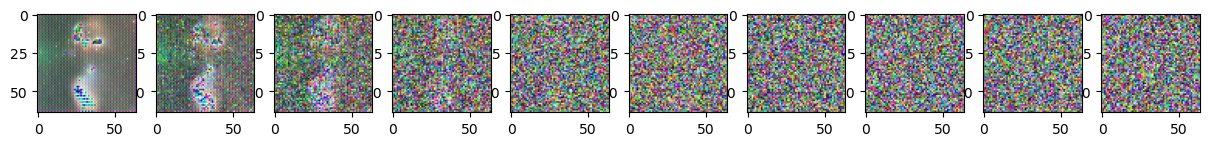

In [ ]:
# model.eval()
sample_plot_image()

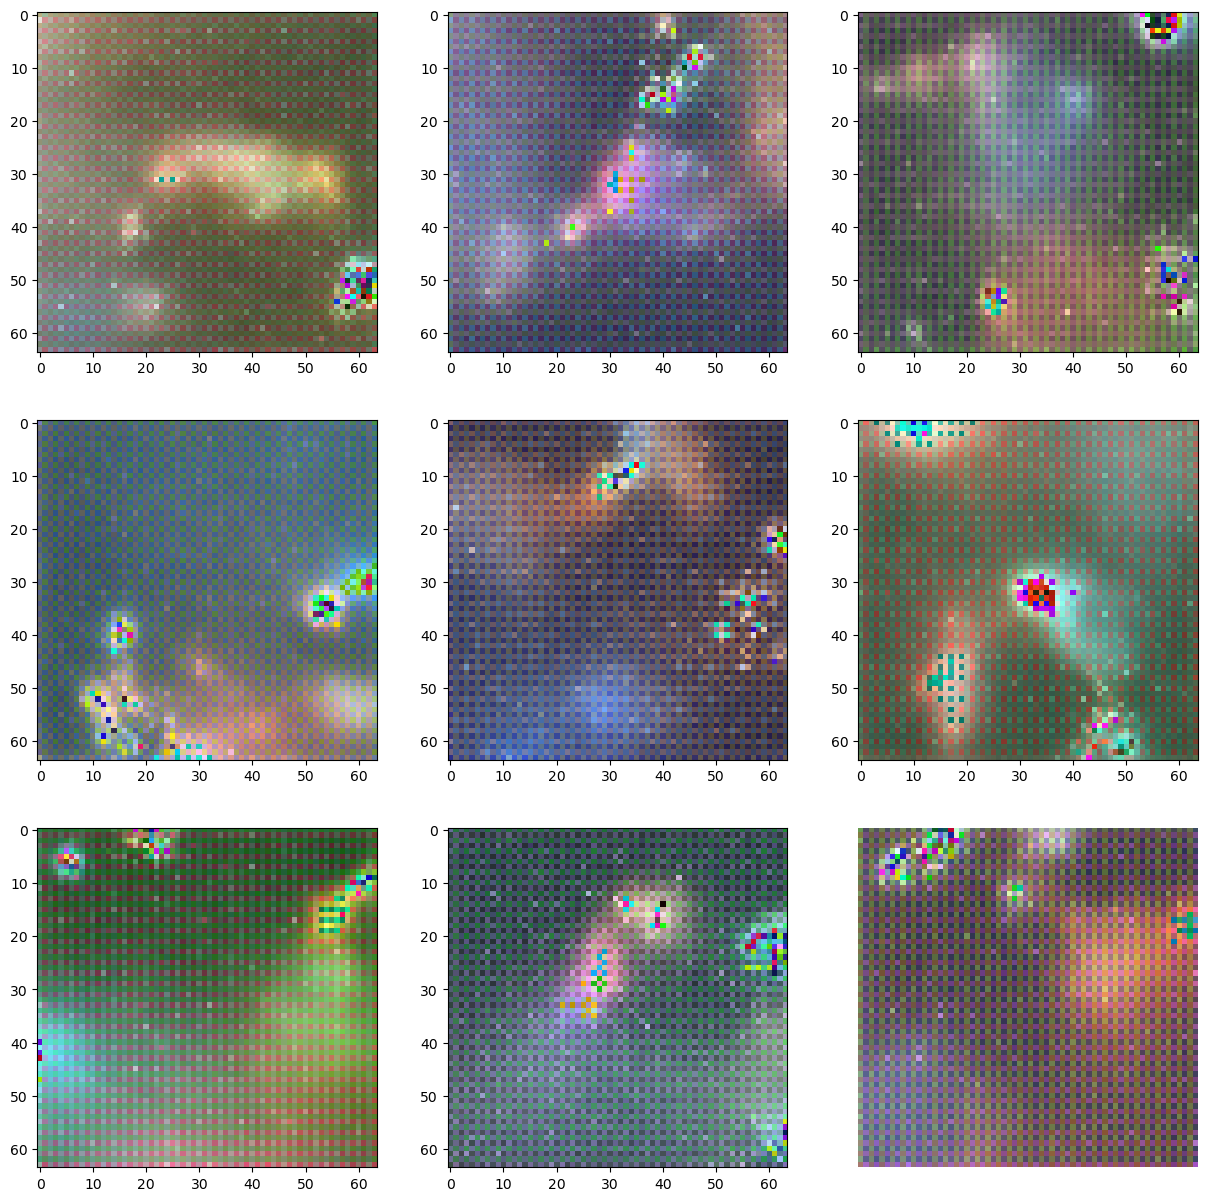

In [ ]:

def show_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    return reverse_transforms(image)
@torch.no_grad()
def generate_image():
    # Sample noise
    img_size = IMG_SIZE
    
    fix,ax = plt.subplots(3,3,figsize=(15,15))
#     plt.figure(figsize=(25,25))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)
    for h in range(3):
        for p in range(3):
            img = torch.randn((1,3 , img_size, img_size), device=device)
            for i in range(0,T)[::-1]:
                t = torch.full((1,), i, device=device, dtype=torch.long)
                img = sample_timestep(img, t)
                if i == 0:
        #             plt.subplot(1, num_images, int(i/stepsize)+1)

                    ax[h][p].imshow(show_image(img.detach().cpu()))
        #     plt.show() 

# for s in range(10):
generate_image()